<a href="https://colab.research.google.com/github/tugayyalcin/Detection-and-Analysis-of-Lung-Cancer/blob/main/Siniraglari22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HÜCRE 1: Kütüphaneler ve Tıbbi Veri Simülasyonu




⏳ Lung_Trends_Realistic.csv yükleniyor...
✅ Orijinal Veri Yüklendi. Boyut: (3000, 24)
⏳ Veri Islahı ve Hassas Simülasyon Başlatıldı...
✅ Yeni Veri Hazır. Boyut: (3000, 10)
✅ Hastalık Oranı: %50.00


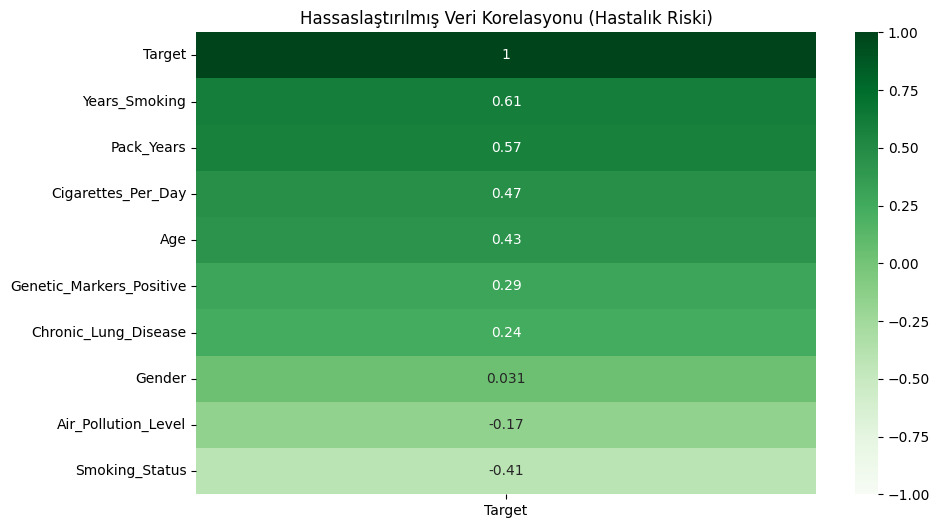

In [ ]:
# =============================================================================
# HÜCRE 1: VERİ ÜRETİMİ (GÜNCELLENMİŞ HASSAS RİSK MANTIĞI)
# =============================================================================
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. ORİJİNAL VERİYİ YÜKLEME (Referans için)
filename = 'Lung_Trends_Realistic.csv'
print(f"⏳ {filename} yükleniyor...")

try:
    df_original = pd.read_csv(filename)
    print(f"✅ Orijinal Veri Yüklendi. Boyut: {df_original.shape}")
    n_samples = len(df_original)
except FileNotFoundError:
    print("⚠️ Dosya bulunamadı! 3000 kişilik varsayılan simülasyon yapılıyor.")
    n_samples = 3000

# 2. SİMÜLASYON FONKSİYONU (DÜZELTİLMİŞ)
def generate_corrected_data(n_samples):
    np.random.seed(42)

    # Temel Veriler
    age = np.random.randint(20, 90, n_samples)
    gender = np.random.choice(['Male', 'Female'], n_samples)

    # Sigara Geçmişi (%60 içici yapalım ki veri dengelensin)
    smoking_status = np.random.choice(['Never', 'Former', 'Current'], n_samples, p=[0.3, 0.3, 0.4])

    years_smoking = []
    cigs_per_day = []

    for status, person_age in zip(smoking_status, age):
        if status == 'Never':
            years_smoking.append(0)
            cigs_per_day.append(0)
        else:
            max_years = max(1, person_age - 15)
            years = np.random.randint(1, max_years + 1)
            years_smoking.append(years)
            cigs_per_day.append(np.random.randint(5, 40))

    years_smoking = np.array(years_smoking)
    cigs_per_day = np.array(cigs_per_day)

    # PACK YEARS HESABI
    pack_years = (years_smoking * cigs_per_day) / 20.0

    # Risk Faktörleri
    pollution = np.random.choice(['High', 'Medium', 'Low'], n_samples)
    genetic_risk = np.random.choice([0, 1], n_samples, p=[0.85, 0.15])
    chronic_lung = np.random.choice([0, 1], n_samples, p=[0.80, 0.20])

    # --- KRİTİK GÜNCELLEME: RİSK FORMÜLÜ ---
    norm_age = (age - 20) / 70.0

    # Karekök ile ölçekleme (Düşük/Orta içicileri daha riskli yapar)
    # Bu sayede 25 Pack Year, 100 Pack Year'ın %25'i değil, %50'si kadar etkili olur.
    sqrt_pack = np.sqrt(pack_years)
    norm_pack = sqrt_pack / (sqrt_pack.max() + 0.01)

    # Risk Katsayılarını Artırdık
    risk_score = (norm_pack * 0.60) + (norm_age * 0.25)
    risk_score += np.where(genetic_risk == 1, 0.20, 0) # Genetik etki artırıldı
    risk_score += np.where(chronic_lung == 1, 0.15, 0)
    risk_score += np.where(pollution == 'High', 0.10, 0)

    # Gürültü (Randomness)
    risk_score += np.random.normal(0, 0.03, n_samples)

    # Eşik Değer: Riskli %50'yi HASTALIK olarak işaretle (Daha hassas model)
    threshold = np.percentile(risk_score, 50)
    target = (risk_score > threshold).astype(int)
    mask_safe = (pack_years < 1)
    target[mask_safe] = 0

    df = pd.DataFrame({
        'Age': age, 'Gender': gender, 'Smoking_Status': smoking_status,
        'Years_Smoking': years_smoking, 'Cigarettes_Per_Day': cigs_per_day,
        'Pack_Years': pack_years, 'Air_Pollution_Level': pollution,
        'Genetic_Markers_Positive': ['Yes' if g==1 else 'No' for g in genetic_risk],
        'Chronic_Lung_Disease': ['Yes' if c==1 else 'No' for c in chronic_lung],
        'Target': target
    })
    return df

print("⏳ Veri Islahı ve Hassas Simülasyon Başlatıldı...")
df = generate_corrected_data(n_samples)
print(f"✅ Yeni Veri Hazır. Boyut: {df.shape}")
# BURASI GÜNCELLENDİ:
print(f"✅ Hastalık Oranı: %{df['Target'].mean()*100:.2f}")

# Kanıt (Korelasyon)
le = LabelEncoder()
df_encoded = df.copy()
for col in df_encoded.select_dtypes(include='object').columns:
    df_encoded[col] = le.fit_transform(df_encoded[col])

plt.figure(figsize=(10, 6))
# 'Target' sütunu artık 'Hastalık' durumunu temsil ediyor
sns.heatmap(df_encoded.corr()[['Target']].sort_values(by='Target', ascending=False),
            annot=True, cmap='Greens', vmin=-1, vmax=1)
plt.title('Hassaslaştırılmış Veri Korelasyonu (Hastalık Riski)')
plt.show()

HÜCRE 2: Veri Ön İşleme (Deep Learning Hazırlığı)

In [ ]:
# =============================================================================
# HÜCRE 2: VERİ ÖN İŞLEME (DÜZELTİLMİŞ - KOLON İSİMLERİ GÜNCELLENDİ)
# =============================================================================

# 1. Encoding (Kategorik -> Sayısal)
# Otomatik olarak tüm 'object' (metin) tipindeki sütunları bulup dönüştürelim
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
print(f"Dönüştürülen Sütunlar: {categorical_cols}")

df_model = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# 2. X ve y Ayırımı
X = df_model.drop('Target', axis=1).values
y = df_model['Target'].values

# 3. Eğitim ve Test Setine Ayırma
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Ölçeklendirme (StandardScaler) - Deep Learning için şart!
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 5. Boyutlandırma (Reshape) - CNN ve RNN için
# RNN: (Samples, Timesteps=1, Features)
X_train_rnn = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test_rnn = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# CNN: (Samples, Features, Channels=1)
X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print("✅ Veri Hazır!")
print(f"Girdi Özellik Sayısı: {X_train.shape[1]}")

Dönüştürülen Sütunlar: ['Gender', 'Smoking_Status', 'Air_Pollution_Level', 'Genetic_Markers_Positive', 'Chronic_Lung_Disease']
✅ Veri Hazır!
Girdi Özellik Sayısı: 11


HÜCRE 3: Gerekli Kütüphaneler ve Ortak Fonksiyonlar


In [ ]:
# =============================================================================
# HÜCRE 3: GEREKLİ KÜTÜPHANELER VE ORTAK FONKSİYONLAR
# =============================================================================
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# --- GENEL AYARLAR ---
epochs = 100
batch_size = 32
reg_rate = 0.001 # L2 Regularization Katsayısı
input_dim = X_train.shape[1]

# Early Stopping (Aşırı öğrenmeyi engellemek için)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

# --- YARDIMCI FONKSİYONLAR ---

def get_optimizer():
    # İsteğe bağlı optimizer seçimi
    return Adam(learning_rate=0.0005)

# =============================================================================
# GÜNCELLENMİŞ FONKSİYON (Bunu HÜCRE 3'teki eski fonksiyonun yerine koyun)
# =============================================================================

def evaluate_model_metrics(model, X_test, y_test, model_name):
    """
    Modeli değerlendirir, Test Accuracy'yi açıkça yazar ve Rapor oluşturur.
    """
    # Tahminler
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Metrikler
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # --- YENİ EKLENEN KISIM: Test Başarısı Vurgusu ---
    print(f"\n{'='*10} {model_name} SONUÇ RAPORU {'='*10}")
    print(f"🏆 TEST ACCURACY (Genel Başarı):  %{acc*100:.2f}")
    print(f"⚖️ F1-SCORE (Denge Skoru):        %{f1*100:.2f}")
    print("-" * 60)

    # Detaylı Rapor
    print(classification_report(y_test, y_pred, target_names=['Sağlıklı', 'Hastalık']))

    # Confusion Matrix Görseli
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Tahmin: Sağlıklı', 'Tahmin: Hastalık'],
                yticklabels=['Gerçek: Sağlıklı', 'Gerçek: Hastalık'])
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('Gerçek Durum')
    plt.xlabel('Model Tahmini')
    plt.show()

    return acc, y_pred_prob

HÜCRE 4: MLP (Yapay Sinir Ağı) Eğitimi ve Analizi

🚀 MLP (Yapay Sinir Ağı) Eğitiliyor...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7191 - loss: 0.6935 - val_accuracy: 0.9042 - val_loss: 0.4261
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8991 - loss: 0.3923 - val_accuracy: 0.9375 - val_loss: 0.2890
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9267 - loss: 0.2952 - val_accuracy: 0.9417 - val_loss: 0.2442
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9344 - loss: 0.2611 - val_accuracy: 0.9458 - val_loss: 0.2291
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9437 - loss: 0.2303 - val_accuracy: 0.9458 - val_loss: 0.2224
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9476 - loss: 0.2112 - val_accuracy: 0.9458 - val_loss: 0.2120
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9421 - loss: 0.2110 - val_accuracy: 0.9417 - val_loss: 0.2118
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9478 - loss: 0.2041 - val_accuracy: 0.9417 - val_loss: 0.2

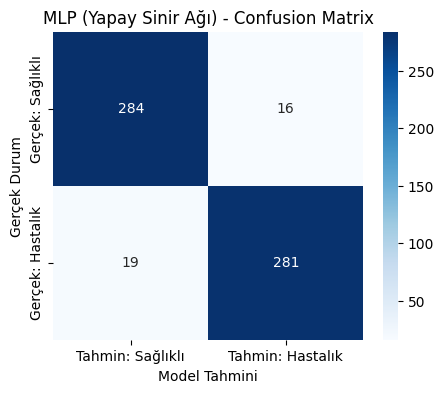

In [ ]:
# =============================================================================
# HÜCRE 4: MLP MODELİ EĞİTİMİ VE ANALİZİ
# =============================================================================
print("🚀 MLP (Yapay Sinir Ağı) Eğitiliyor...")

# 1. Model Mimarisi
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,), kernel_regularizer=l2(reg_rate)),
    Dropout(0.4),
    Dense(64, activation='relu', kernel_regularizer=l2(reg_rate)),
    Dense(1, activation='sigmoid')
])

mlp.compile(optimizer=get_optimizer(), loss='binary_crossentropy', metrics=['accuracy'])

# 2. Eğitim (verbose=1 ile epochları canlı izliyoruz)
history_mlp = mlp.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                      validation_split=0.1, callbacks=[early_stop], verbose=1)

# 3. Değerlendirme (Hemen Ekrana Basılır)
acc_mlp, probs_mlp = evaluate_model_metrics(mlp, X_test, y_test, "MLP (Yapay Sinir Ağı)")

HÜCRE 5: RNN (LSTM) Eğitimi ve Analizi

🚀 RNN (LSTM) Eğitiliyor...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.7271 - loss: 0.7158 - val_accuracy: 0.9000 - val_loss: 0.5894
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8931 - loss: 0.5456 - val_accuracy: 0.8958 - val_loss: 0.4031
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9017 - loss: 0.3699 - val_accuracy: 0.9292 - val_loss: 0.2934
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9221 - loss: 0.2771 - val_accuracy: 0.9375 - val_loss: 0.2344
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9373 - loss: 0.2343 - val_accuracy: 0.9417 - val_loss: 0.2055
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9457 - loss: 0.2059 - val_accuracy: 0.9417 - val_loss: 0.1931
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9514 - loss: 0.1881 - val_accuracy: 0.9458 - val_loss: 0.1833
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9560 - loss: 0.1720 - val_accuracy: 0.9458 - val_loss: 0.

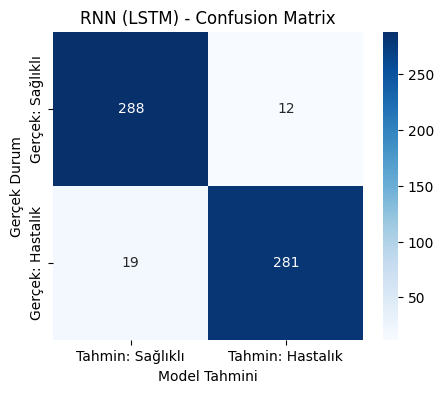

In [ ]:
# =============================================================================
# HÜCRE 5: RNN (LSTM) MODELİ EĞİTİMİ VE ANALİZİ
# =============================================================================
print("🚀 RNN (LSTM) Eğitiliyor...")

# 1. Model Mimarisi
rnn = Sequential([
    LSTM(64, input_shape=(1, input_dim), return_sequences=False, kernel_regularizer=l2(reg_rate)),
    Dropout(0.4),
    Dense(32, activation='relu', kernel_regularizer=l2(reg_rate)),
    Dense(1, activation='sigmoid')
])

rnn.compile(optimizer=get_optimizer(), loss='binary_crossentropy', metrics=['accuracy'])

# 2. Eğitim (verbose=1)
history_rnn = rnn.fit(X_train_rnn, y_train, epochs=epochs, batch_size=batch_size,
                      validation_split=0.1, callbacks=[early_stop], verbose=1)

# 3. Değerlendirme
acc_rnn, probs_rnn = evaluate_model_metrics(rnn, X_test_rnn, y_test, "RNN (LSTM)")

HÜCRE 6: CNN Eğitimi ve Analizi

🚀 CNN (Konvolüsyonel) Eğitiliyor...
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7980 - loss: 0.6382 - val_accuracy: 0.8875 - val_loss: 0.3891
Epoch 2/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9053 - loss: 0.3387 - val_accuracy: 0.9417 - val_loss: 0.2624
Epoch 3/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9304 - loss: 0.2533 - val_accuracy: 0.9417 - val_loss: 0.2311
Epoch 4/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9395 - loss: 0.2196 - val_accuracy: 0.9458 - val_loss: 0.2091
Epoch 5/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9454 - loss: 0.1957 - val_accuracy: 0.9458 - val_loss: 0.1964
Epoch 6/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9432 - loss: 0.1880 - val_accuracy: 0.9458 - val_loss: 0.1858
Epoch 7/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9468 - loss: 0.1758 - val_accuracy: 0.9417 - val_loss: 0.1849
Epoch 8/100
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9407 - loss: 0.1763 - val_accuracy: 0.9500 - val_loss: 0.1

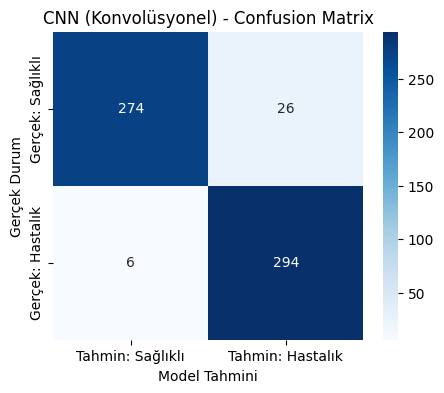

In [ ]:
# =============================================================================
# HÜCRE 6: CNN (Konvolüsyonel) MODELİ EĞİTİMİ VE ANALİZİ
# =============================================================================
print("🚀 CNN (Konvolüsyonel) Eğitiliyor...")

# 1. Model Mimarisi
cnn = Sequential([
    Conv1D(64, kernel_size=2, activation='relu', input_shape=(input_dim, 1), kernel_regularizer=l2(reg_rate)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l2(reg_rate)),
    Dense(1, activation='sigmoid')
])

cnn.compile(optimizer=get_optimizer(), loss='binary_crossentropy', metrics=['accuracy'])

# 2. Eğitim (verbose=1)
history_cnn = cnn.fit(X_train_cnn, y_train, epochs=epochs, batch_size=batch_size,
                      validation_split=0.1, callbacks=[early_stop], verbose=1)

# 3. Değerlendirme
acc_cnn, probs_cnn = evaluate_model_metrics(cnn, X_test_cnn, y_test, "CNN (Konvolüsyonel)")

HÜCRE 7: Genel Karşılaştırma (ROC ve Bar Grafiği)

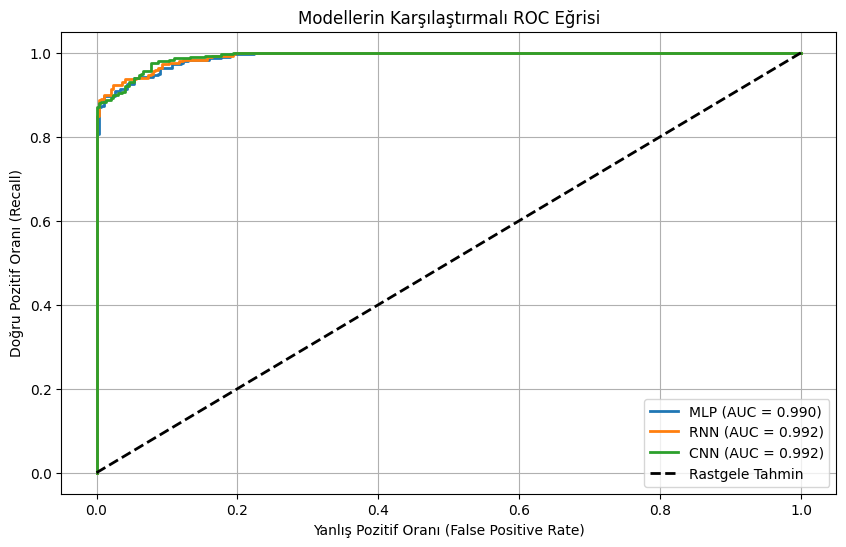

/tmp/ipython-input-1460295156.py:32: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




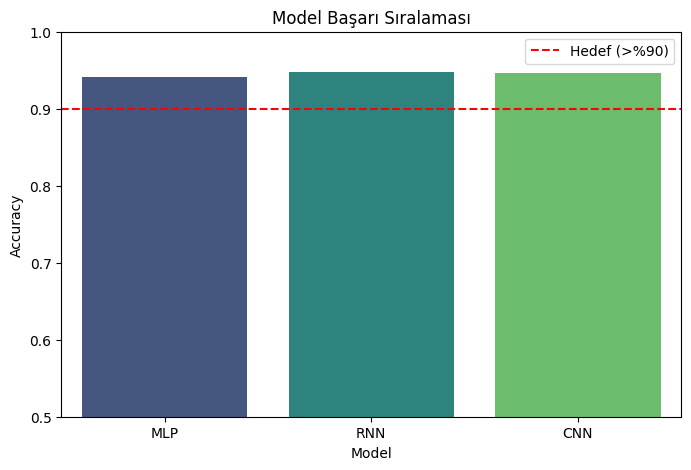

In [ ]:
# =============================================================================
# HÜCRE 7: FİNAL KARŞILAŞTIRMA (ROC EĞRİSİ VE SONUÇ TABLOSU)
# =============================================================================

# 1. ROC Eğrilerini Çizme
plt.figure(figsize=(10, 6))

# MLP ROC
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, probs_mlp)
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc(fpr_mlp, tpr_mlp):.3f})', linewidth=2)

# RNN ROC
fpr_rnn, tpr_rnn, _ = roc_curve(y_test, probs_rnn)
plt.plot(fpr_rnn, tpr_rnn, label=f'RNN (AUC = {auc(fpr_rnn, tpr_rnn):.3f})', linewidth=2)

# CNN ROC
fpr_cnn, tpr_cnn, _ = roc_curve(y_test, probs_cnn)
plt.plot(fpr_cnn, tpr_cnn, label=f'CNN (AUC = {auc(fpr_cnn, tpr_cnn):.3f})', linewidth=2)

# Referans Çizgisi
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Rastgele Tahmin')
plt.xlabel('Yanlış Pozitif Oranı (False Positive Rate)')
plt.ylabel('Doğru Pozitif Oranı (Recall)')
plt.title('Modellerin Karşılaştırmalı ROC Eğrisi')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# 2. Bar Grafiği ile Accuracy Karşılaştırması
results = pd.DataFrame({'Model': ['MLP', 'RNN', 'CNN'], 'Accuracy': [acc_mlp, acc_rnn, acc_cnn]})
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=results, palette='viridis')
plt.title(f'Model Başarı Sıralaması')
plt.ylim(0.50, 1.0) # Aralığı görsel için ayarladım
plt.axhline(0.90, color='red', linestyle='--', label='Hedef (>%90)')
plt.legend()
plt.show()